In [1]:
import pandas as pd 
import numpy as np
import glob
import ast
import random
import matplotlib.pyplot as plt
import matplotlib.colors
from numpy.polynomial import polynomial as P
from scipy.interpolate import splprep, splev
from scipy.integrate import quad
from scipy.spatial import distance
import surface_distance as sd
import similaritymeasures
import seaborn as sns
import math
from scipy.interpolate import make_interp_spline, BSpline
from sklearn import preprocessing as pre
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
files = glob.glob('../data/geometry_results_dl/*.csv')
dfs = []
for file in files:
    dfs.append(pd.read_csv(file))
df = pd.concat(dfs, ignore_index=True)

In [440]:
def get_interpolated_endplate_contour(df, index, cranial_caudal):

    location = f'{cranial_caudal}_endplate_line'
    endplate = df[location][index]
    # vb_height = df[f'{cranial_caudal}_vb_height'][index] 
    vb_height = df['cranial_vb_height'][index] # scaling only by the cranial VB height for the purposes of plotting

    # convert the line string to a list of tuples
    endplate = ast.literal_eval(endplate)

    # convert the list of tuples to a numpy array
    endplate = np.array(endplate)

    # scale endplate using the value for the IVD height
    endplate = endplate / vb_height

    endplate_x = endplate[:,0]

    endplate_y = endplate[:,1]

    # get a new endplate line that consists of equispaced points along the original line to minimise the pixelation effect:
    xd = np.diff(endplate_x)
    yd = np.diff(endplate_y)
    dist = np.sqrt(xd**2+yd**2)
    u = np.cumsum(dist)
    u = np.hstack([[0],u])
    n_points = round(30 * u[-1]) # choose the number of points based on the total length of the line (longer lines get more points)
    # print('Endplate length: ', u[-1])
    # print(n_points)
    t = np.linspace(0,u.max(),n_points)
    endplate_x = np.interp(t, u, endplate_x)
    endplate_y = np.interp(t, u, endplate_y)

    # remove some points from either end of the line to reduce impact of the corners
    n_to_remove = n_points // 10
    endplate_x = endplate_x[n_to_remove:-n_to_remove]
    endplate_y = endplate_y[n_to_remove:-n_to_remove]

    return endplate_x, endplate_y


def fit_straight_line_to_endplate(endplate_x, endplate_y):
    # fit a straight line to the endplate line
    coefs_1, polynomial_fit_error_1 = P.polyfit(endplate_x, endplate_y, 1, full=True)
    ffit_1 = P.Polynomial(coefs_1)
    return ffit_1


def fit_polynomial_to_endplate(endplate_x, endplate_y, degree):
    # fit a polynomial to the endplate line
    coefs, polynomial_fit_error = P.polyfit(endplate_x, endplate_y, degree, full=True)
    ffit_n = P.Polynomial(coefs)
    return ffit_n


def get_angle_between_vectors(x, y, fit_y):
    # get the angle between two vectors
    angles_contour = []
    angles_fit = []
    angle_diffs = []
    for idx in range(len(x)-1):
        x0, y0, x1, y1 = x[idx], y[idx], x[idx+1], y[idx+1]
        # get the angle of this vector
        # if x1 - x0 == 0:
        #     slope = 0
        # else:
        #     slope = (y1 - y0)/(x1 - x0)
        angle_contour = np.rad2deg(np.arctan2(y1 - y0, x1 - x0))
        # angle_contour = math.degrees(slope)
        angles_contour.append(angle_contour)

        y0_fit, y1_fit = fit_y[idx], fit_y[idx+1]
        # get the angle of the fitted vector
        # if x1 - x0 == 0:
        #     slope_fit = 0
        # else:
        #     slope_fit = (y1_fit - y0_fit)/(x1 - x0)
        # angle_fit = math.degrees(slope_fit)
        angle_fit = np.rad2deg(np.arctan2(y1_fit - y0_fit, x1 - x0))
        angles_fit.append(angle_fit)

        # get the absolute difference in angle between the two vectors
        difference = 180 - abs(abs(angle_contour - angle_fit) - 180)

        if difference > 90:
            difference = 180 - difference

        angle_diffs.append(difference)

    return angles_contour, angles_fit, angle_diffs


# moving them to origin zero and rotating them as necessary

def move_to_origin(l):
    # move the start of the contour to zero
    x0, y0 = l[0]
    return [(x - x0, y - y0) for x, y in l]

def rotate_to_x_axis(l):
    xn, yn = l[-1] # calculate the angle of the last point in the list to the origin and rotate the list of points by that angle
    theta = math.atan2(-yn, xn)
    return [(x*math.cos(theta) - y*math.sin(theta), x*math.sin(theta) + y*math.cos(theta)) for x, y in l]


31673


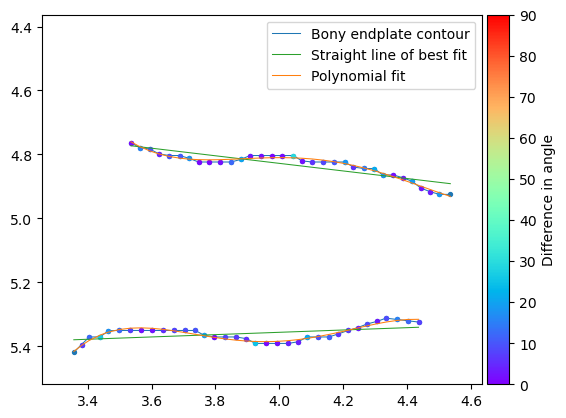

In [1082]:
# generate a random index from the df
random_index = random.randint(0, len(df))
# random_index = 23526 # Schmorl's node
# random_index = 8996 # Schmorl's node
# random_index = 3186 # Very large Schmorl's node
# random_index = 37149 # very concave or possibly Schmorl's node
# random_index = 5164 # Classic polynomial curve
# random_index = 41660 # Large curve but no focal defect
# random_index = 33695 # Large curve but no focal defect
# random_index = 40523 # angle results look wrong
# random_index = 22648 # problem?
print(random_index)
project_ID = df['project_ID'][random_index]
slice_number = df['slice_number'][random_index]
level = df['level'][random_index]

# Getting basic contour lines
cranial_x, cranial_y = get_interpolated_endplate_contour(df, random_index, 'cranial')
caudal_x, caudal_y = get_interpolated_endplate_contour(df, random_index, 'caudal')

# # put cranial x and cranial y in list of lists to work for the function above:
# cranial_xy = []
# for i in range(len(cranial_x)):
#     cranial_xy.append([cranial_x[i], cranial_y[i]])

# caudal_xy = []
# for i in range(len(caudal_x)):
#     caudal_xy.append([caudal_x[i], caudal_y[i]])

# cranial_xy_rotated = rotate_to_x_axis(move_to_origin(cranial_xy))
# caudal_xy_rotated = rotate_to_x_axis(move_to_origin(caudal_xy))

# # separate cranial_xy_rotated into x and y
# cranial_x = []
# cranial_y = []
# for i in range(len(cranial_xy_rotated)):
#     cranial_x.append(cranial_xy_rotated[i][0])
#     cranial_y.append(cranial_xy_rotated[i][1])

# caudal_x = []
# caudal_y = []
# for i in range(len(caudal_xy_rotated)):
#     caudal_x.append(caudal_xy_rotated[i][0])
#     caudal_y.append(caudal_xy_rotated[i][1])

# # convert to numpy arrays
# cranial_x = np.array(cranial_x)
# cranial_y = np.array(cranial_y)

# caudal_x = np.array(caudal_x)
# caudal_y = np.array(caudal_y)

# Getting the straight and polynomial fit to the (normalised) endplate line
cranial_ffit_1 = fit_straight_line_to_endplate(cranial_x, cranial_y)
cranial_ffit_n = fit_polynomial_to_endplate(cranial_x, cranial_y, 4)

caudal_ffit_1 = fit_straight_line_to_endplate(caudal_x, caudal_y)
caudal_ffit_n = fit_polynomial_to_endplate(caudal_x, caudal_y, 4)

# get average slopes from the second to the last point (no slope for the last point, so we also remove the first point)
cranial_poly_line = cranial_ffit_n(cranial_x)
cranial_angles_contour, cranial_angles_fit, cranial_angle_diffs = get_angle_between_vectors(cranial_x, cranial_y, cranial_poly_line)

caudal_poly_line = caudal_ffit_n(caudal_x)
caudal_angles_contour, caudal_angles_fit, caudal_angle_diffs = get_angle_between_vectors(caudal_x, caudal_y, caudal_poly_line)

# Plotting
palette_tab10 = sns.color_palette("tab10", 10)
fig, ax = plt.subplots()
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=0, vmax=90)
s = 8
lw = 0.75

# plot the endplate contours
plt.plot(cranial_x, cranial_y, label = "Bony endplate contour", linewidth = lw, color = palette_tab10[0], zorder = 1)
plt.scatter(cranial_x, cranial_y, s=s,  color = palette_tab10[0], zorder = 2)

plt.plot(caudal_x, caudal_y, linewidth = lw, color = palette_tab10[0], zorder = 1)
plt.scatter(caudal_x, caudal_y, s=s,  color = palette_tab10[0], zorder = 2)

# plot the straight fit line
plt.plot(cranial_x, cranial_ffit_1(cranial_x), label = "Straight line of best fit", linewidth = lw, color = palette_tab10[2], zorder = 5)
plt.plot(caudal_x, caudal_ffit_1(caudal_x), linewidth = lw, color = palette_tab10[2], zorder = 5)

# plot the polynomial fit line
plt.plot(cranial_x, cranial_ffit_n(cranial_x), label = "Polynomial fit", linewidth = lw, color = palette_tab10[1], zorder = 5)
# plt.scatter(cranial_x, cranial_ffit_n(cranial_x), s=s,  color = palette_tab10[1], zorder = 6)
plt.plot(caudal_x, caudal_ffit_n(caudal_x), linewidth = lw, color = palette_tab10[1], zorder = 5)
# plt.scatter(caudal_x, caudal_ffit_n(caudal_x), s=s,  color = palette_tab10[1], zorder = 6)

for i in range(len(cranial_angle_diffs)):
    ax.scatter(cranial_x[i], cranial_y[i], c=cranial_angle_diffs[i], s=s, cmap=cmap, norm=norm, zorder = 3)

for i in range(len(caudal_angle_diffs)):
    ax.scatter(caudal_x[i], caudal_y[i], c=caudal_angle_diffs[i], s=s, cmap=cmap, norm=norm, zorder = 3)

plt.axis('scaled')
x_min = min(cranial_x.min(), caudal_x.min()) - 0.1
x_max = max(cranial_x.max(), caudal_x.max()) + 0.1
y_min = min(cranial_y.min(), caudal_y.min()) - 0.4
y_max = max(cranial_y.max(), caudal_y.max()) + 0.1
# x_min = cranial_x.min() - 0.1
# x_max = cranial_x.max() + 0.1
# y_min = cranial_y.min() - 0.4
# y_max = cranial_y.max() + 0.4
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.gca().invert_yaxis()
plt.legend()
# add a colourbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sm, cax=cax, label = "Difference in angle")
plt.show()
# fig.savefig(f'../../../Desktop/{project_ID}_IMG000{slice_number}_{level}_local_angle_difference.pdf',format='pdf')
# fig.savefig('../../../Desktop/test.pdf', format='pdf')
